# 1. Data preparation

When using colab execute the 2 next cells.

Because Colab is quite slow to read images directly from Drive a better solution than changing directory is to unzip a file directly (cf. https://stackoverflow.com/questions/59120853/google-colab-is-so-slow-while-reading-images-from-google-drive).

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#Path pour Martin
# % cd drive/MyDrive/MVA/Medical\ Imagery/

#Path pour Clement
# %cd drive/MyDrive/Medical\ Imagery/
!unzip "drive/MyDrive/Medical Imagery/data.zip" -d "/data"

/content/drive/MyDrive/Medical Imagery


In [ ]:
import pandas as pd  
import os
import numpy as np
from torch.utils.data import Dataset

In [ ]:
patient_size = {}
for path in os.listdir("../data/trainset"):
    if path[0] == "P":
        patient_size[path] = len(os.listdir(f"../data/trainset/{path}"))
for path in os.listdir("../data/testset"):
    if path[0] == "P":
        patient_size[path] = len(os.listdir(f"../data/testset/{path}"))

patient_size_frame = pd.Series(patient_size)
patient_size_frame.head()

P0      87
P1      80
P10     32
P100    43
P101    52
dtype: int64

<AxesSubplot:>

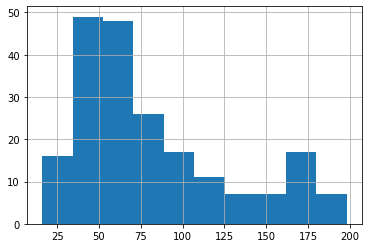

In [ ]:
patient_size_frame.hist()

In [ ]:
patient_size_frame.sort_values()

P62      16
P28      20
P73      26
P164     28
P47      28
       ... 
P85     183
P46     187
P184    188
P111    194
P35     198
Length: 205, dtype: int64

Max number of blood smears for a single patient is reached by P35 with 198.

In order to have the same number of images available for every patient we augment each one of them with random sampling in order to obtain 200 images when `fill_img_list` argument of our dataset is set to `True`.

In [ ]:
import os
from os import path
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import Dataset


class LymphocytosisDataset(Dataset):
    # nb_img_fill represents the a common maximum for
    nb_img_fill = 200

    def __init__(
        self,
        annotation_csv: str,
        root_dir: str,
        train: bool = True,
        transform: callable = None,
        fill_img_list: bool = False,
        split_label: bool = False,
    ) -> None:
        """
        Loads Lymphocytosis data

        Parameters
        ----------
        annotation_csv : str
            Path to the csv file that contains annotation for every patient
        root_dir : str
            Directory with all the images
        train : bool
            Wether to use training images or not
        transform : callable, optional
            Optional transform to be applied on sample images, by default None
        """
        ## Get the clinical annotation
        self.annotation_frame = pd.read_csv(annotation_csv, index_col=0)
        ## Identify training and testing ids
        self.train_ids = list(
            self.annotation_frame["ID"][self.annotation_frame["LABEL"] != -1]
        )
        self.test_ids = list(
            self.annotation_frame["ID"][self.annotation_frame["LABEL"] == -1]
        )
        ## Reindex the annotation to the "ID" column
        self.annotation_frame = self.annotation_frame.set_index("ID")
        ## Handle "DOB" column
        DOB = self.annotation_frame["DOB"].copy()
        line_with_slash = DOB.str.contains("/")
        DOB[line_with_slash] = pd.to_datetime(DOB[line_with_slash], format="%m/%d/%Y")
        DOB[~line_with_slash] = pd.to_datetime(DOB[~line_with_slash], format="%d-%m-%Y")
        self.annotation_frame["DOB"] = pd.to_datetime(DOB)

        ## Define instance attributes
        self.root_dir = root_dir
        self.train = train
        self.transform = transform
        self.fill_img_list = fill_img_list
        self.split_label = split_label

    def __len__(self) -> int:
        if self.train:
            return len(self.train_ids)
        else:
            return len(self.test_ids)

    def __getitem__(self, index: int) -> tuple:
        if self.train:
            id = self.train_ids[index]
        else:
            id = self.test_ids[index]
        annotation = self.annotation_frame.loc[id]
        img_dir = f"{self.root_dir}/{'train' if self.train else 'test'}set/{id}/"
        img_list = [
            Image.open(os.path.join(img_dir, img_name))
            for img_name in os.listdir(img_dir)
        ]
        if self.fill_img_list:
            missing = self.nb_img_fill - len(img_list)
            filling_indices = np.random.randint(len(img_list), size=missing)
            for index in filling_indices:
                img_list.append(img_list[index])
        if self.split_label:
            label = annotation["LABEL"]
            annotation = annotation.drop("LABEL")
            return annotation, img_list, label
        return annotation, img_list


In [ ]:
annotation_path = "../data/clinical_annotation.csv"
images_dir = "../data"
trainset = LymphocytosisDataset(annotation_path, images_dir, train=True, fill_img_list=True, split_label=False)

In [ ]:
%time trainset[1]

Wall time: 32 ms


(LABEL                            1
 GENDER                           M
 DOB            1942-05-15 00:00:00
 LYMPH_COUNT                   12.8
 Name: P183, dtype: object,
 [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x2045777ED30>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x2045756F7C0>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x2045777EBE0>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x204587D7DC0>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x204587D79A0>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x204587D7F70>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x20452B37D00>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x204587D7DF0>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x204587F2220>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x20

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:xlabel='LYMPH_COUNT', ylabel='Count'>

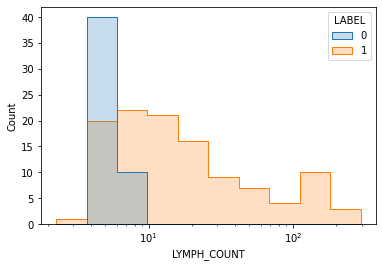

In [ ]:
annotation_train = trainset.annotation_frame[trainset.annotation_frame["LABEL"] != -1]
sns.histplot(data=annotation_train, x="LYMPH_COUNT", hue="LABEL", log_scale=True, element="step")

In [ ]:
df = pd.read_csv("data/clinical_annotation.csv")  
df.head()

,Unnamed: 0,ID,LABEL,GENDER,DOB,LYMPH_COUNT
0,0,P26,1,M,11/3/1933,11.2
1,1,P183,1,M,5/15/1942,12.8
2,2,P89,1,M,6/19/1935,9.6
3,3,P123,1,M,1/27/1931,122.6
4,4,P61,1,F,3/5/1931,11.6


In [ ]:
sick = df[df.LABEL>0].shape[0]
test = df[df.LABEL==-1].shape[0]
reactive = df[df.LABEL==0].shape[0]


males = df[(df.GENDER=='M') & (df.LABEL>=0)].shape[0]
females = df[(df.GENDER=='F') & (df.LABEL>=0)].shape[0]

sick_females = df[(df.GENDER=='F') & (df.LABEL==1)].shape[0]
reactive_females = df[(df.GENDER=='F') & (df.LABEL==0)].shape[0]
sick_males = df[(df.GENDER=='M') & (df.LABEL==0)].shape[0]
reactive_males = df[(df.GENDER=='M') & (df.LABEL==1)].shape[0]


print('we have {} sick, {} reactive, and {} test cases in the set'.format(sick, reactive, test))

print('we have {} male and {} female patients in the training+validation set'.format(males, females))
print('{} of the female patients and {} of the male patients are sick in the train + validation set'.format(sick_females, sick_males))

we have 113 sick, 50 reactive, and 42 test cases in the set
we have 82 male and 81 female patients in the training+validation set
55 of the female patients and 24 of the male patients are sick in the train + validation set


In [ ]:
YOB = list(df['DOB'])
for i in range (len(YOB)):
  YOB[i] = YOB[i][-4:]


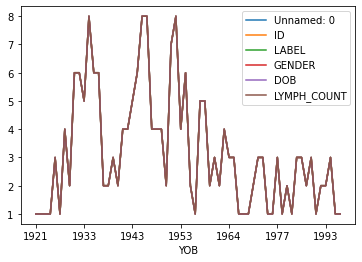

In [ ]:
df['YOB'] = YOB
df.groupby('YOB').count().plot()

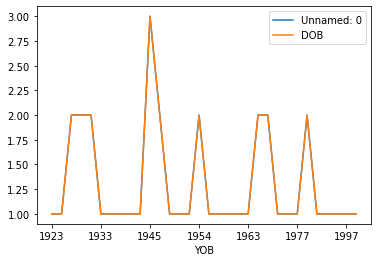

In [ ]:
df_test = df[df.LABEL==-1]
df_test = df_test.drop(columns=['ID', 'LABEL', 'GENDER', 'LYMPH_COUNT'])
df_test.groupby('YOB').count().plot()

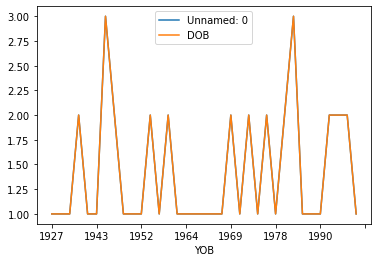

In [ ]:
df_reactive = df[df.LABEL==0]
df_reactive = df_reactive.drop(columns=['ID', 'LABEL', 'GENDER', 'LYMPH_COUNT'])
df_reactive.groupby('YOB').count().plot()

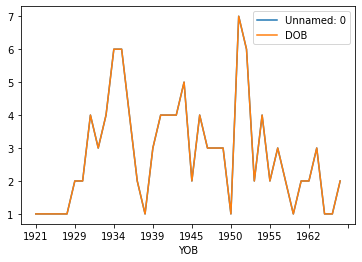

In [ ]:
df_sick = df[df.LABEL==1]
df_sick = df_sick.drop(columns=['ID', 'LABEL', 'GENDER', 'LYMPH_COUNT'])
df_sick.groupby('YOB').count().plot()